# ETF Return & Simulation Analysis for PEAK6 Interview

This notebook analyzes historical data for the following ETFs:  
**SPY, XLU, IGV, SMH, ARKK, XLE, QQQ, XLK**  
We compute risk/return metrics, plot various visualizations, and perform Monte Carlo simulations to project possible price paths for 1 year (assumed as the rest of 2025).  

Our goal is to identify which ETF might have the fattest right tail – meaning the greatest chance of extreme positive returns.

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Use a clean style for plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [5]:
# Define the ETFs and download historical data
etfs = ["SPY", "XLU", "IGV", "SMH", "ARKK", "XLE", "QQQ", "XLK"]
# Download 4 years of data; adjust dates as needed
start_date = '2020-01-01'
end_date = '2023-12-31'
data = yf.download(etfs, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# Display the first few rows of data
data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,ARKK,IGV,QQQ,SMH,SPY,XLE,XLK,XLU
Date,,,,,,,,
2020-01-02,48.890053,47.159706,209.638031,69.920448,301.194977,48.587868,89.251068,54.408096
2020-01-03,48.531849,46.988758,207.717773,68.775078,298.914093,48.443501,88.247574,54.518932
2020-01-06,48.909416,47.537380,209.056198,68.040497,300.054565,48.820454,88.457848,54.570084
2020-01-07,49.509651,47.664600,209.027084,69.176193,299.210907,48.692127,88.419601,54.493359
2020-01-08,50.622986,48.167503,210.598175,69.292183,300.805542,47.890083,89.365753,54.467773


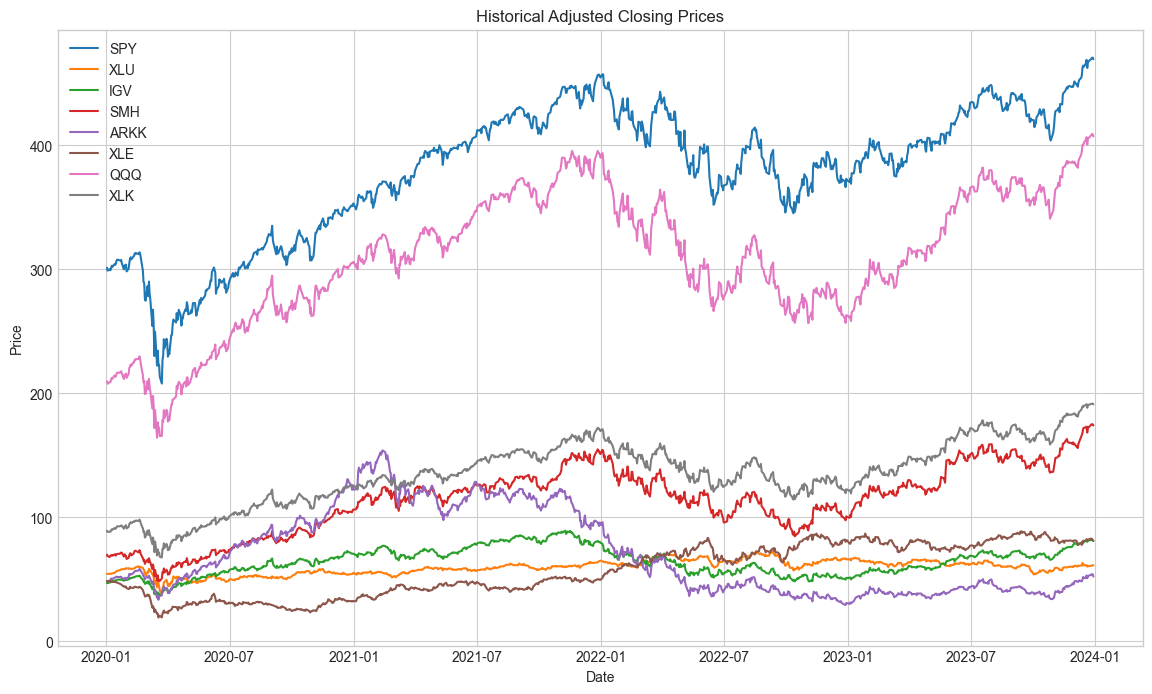

In [6]:
# Plot historical adjusted closing prices
plt.figure(figsize=(14,8))
for etf in etfs:
    plt.plot(data.index, data[etf], label=etf)
plt.title("Historical Adjusted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [7]:
# Calculate daily log returns for each ETF
log_returns = np.log(data / data.shift(1)).dropna()

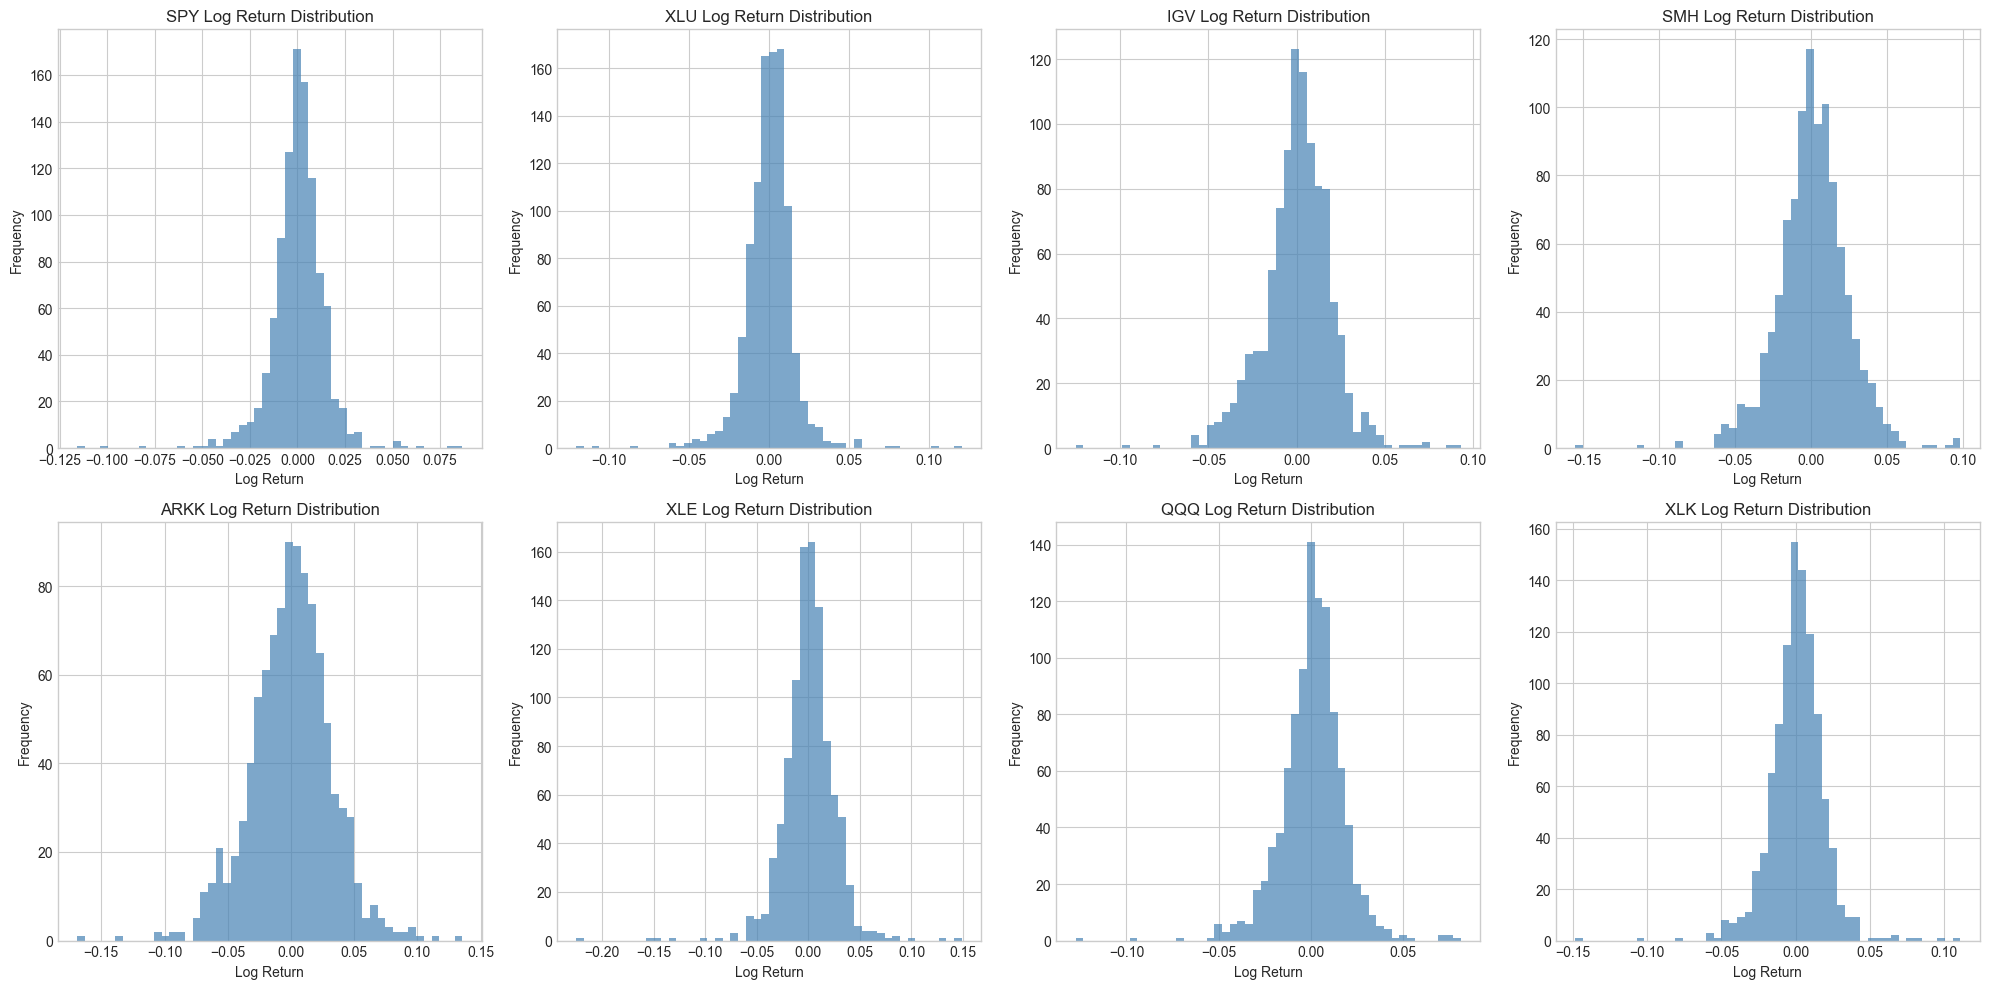

In [8]:
# Plot histogram of log returns for each ETF
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()
for i, etf in enumerate(etfs):
    axes[i].hist(log_returns[etf], bins=50, alpha=0.7, color='steelblue')
    axes[i].set_title(f"{etf} Log Return Distribution")
    axes[i].set_xlabel("Log Return")
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [9]:
# Calculate descriptive statistics: mean, volatility, skewness, kurtosis, and VaR (5% quantile)
desc_stats = pd.DataFrame(index=etfs, columns=["Mean", "Volatility", "Skewness", "Kurtosis", "VaR_5%"])
for etf in etfs:
    desc_stats.loc[etf, "Mean"] = log_returns[etf].mean()
    desc_stats.loc[etf, "Volatility"] = log_returns[etf].std()
    desc_stats.loc[etf, "Skewness"] = log_returns[etf].skew()
    desc_stats.loc[etf, "Kurtosis"] = log_returns[etf].kurtosis()
    desc_stats.loc[etf, "VaR_5%"] = np.percentile(log_returns[etf], 5)

desc_stats = desc_stats.astype(float)
print("Descriptive Statistics:")
print(desc_stats)

Descriptive Statistics:
          Mean  Volatility  Skewness   Kurtosis    VaR_5%
SPY   0.000441    0.014315 -0.773011  11.133719 -0.020587
XLU   0.000120    0.015684 -0.139208  13.027944 -0.021208
IGV   0.000540    0.019608 -0.359736   3.558094 -0.032744
SMH   0.000908    0.023297 -0.298094   3.561851 -0.037353
ARKK  0.000068    0.031921 -0.203355   1.603482 -0.055693
XLE   0.000510    0.025231 -0.881045  11.479311 -0.035592
QQQ   0.000660    0.017214 -0.537503   5.741532 -0.027056
XLK   0.000758    0.018450 -0.408155   8.048258 -0.026951


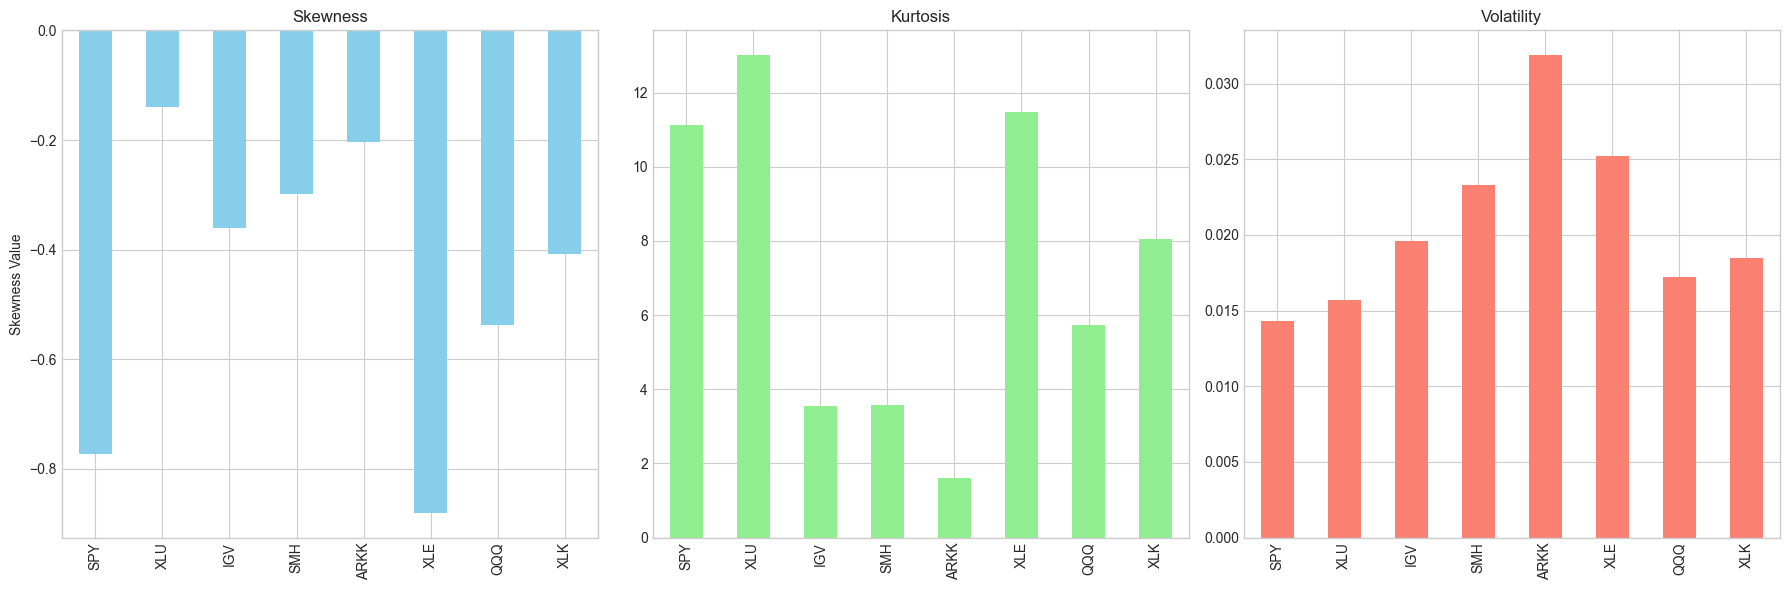

In [10]:
# Bar charts for skewness, kurtosis, and volatility for a side-by-side comparison
fig, axs = plt.subplots(1, 3, figsize=(18,6))
desc_stats['Skewness'].plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title("Skewness")
axs[0].set_ylabel("Skewness Value")
desc_stats['Kurtosis'].plot(kind='bar', ax=axs[1], color='lightgreen')
axs[1].set_title("Kurtosis")
desc_stats['Volatility'].plot(kind='bar', ax=axs[2], color='salmon')
axs[2].set_title("Volatility")
plt.tight_layout()
plt.show()

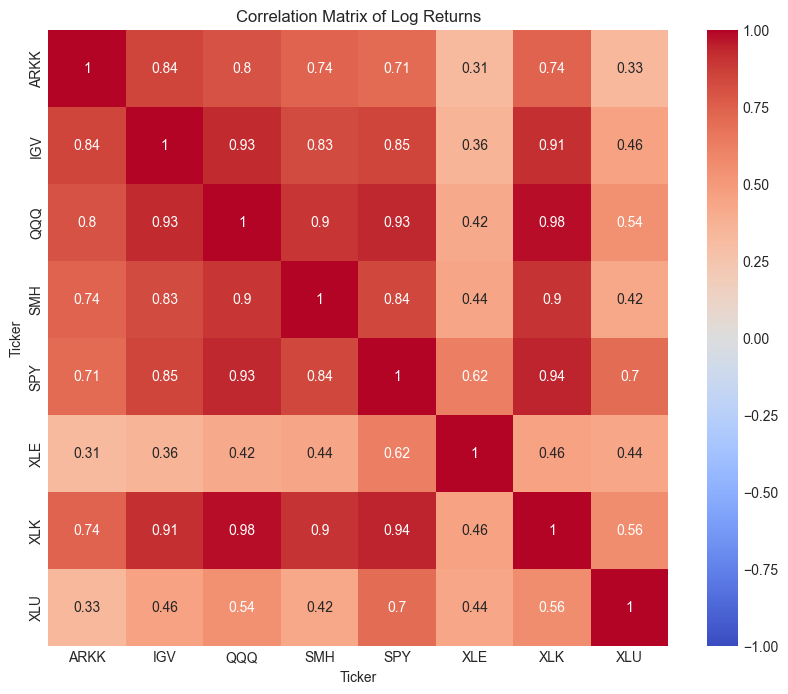

In [11]:
# Plot the correlation heatmap of log returns to see how ETFs move relative to each other
plt.figure(figsize=(10,8))
corr = log_returns.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Log Returns")
plt.show()

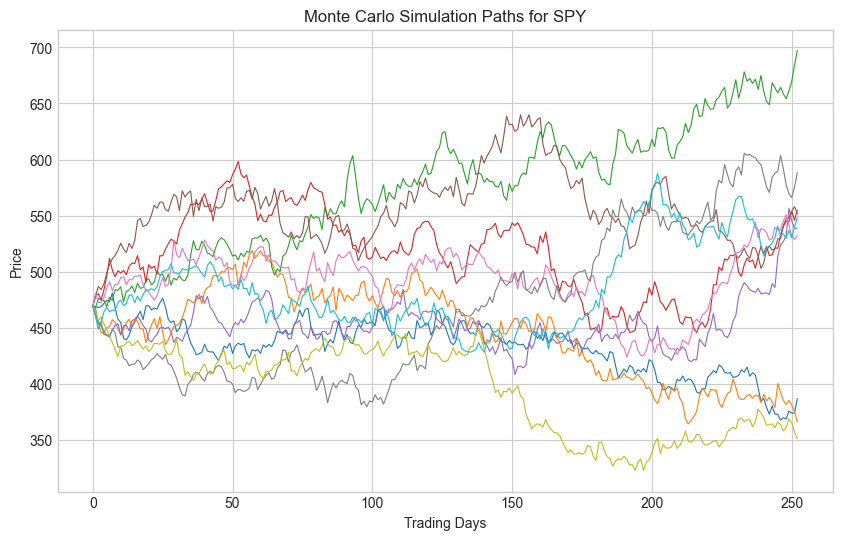

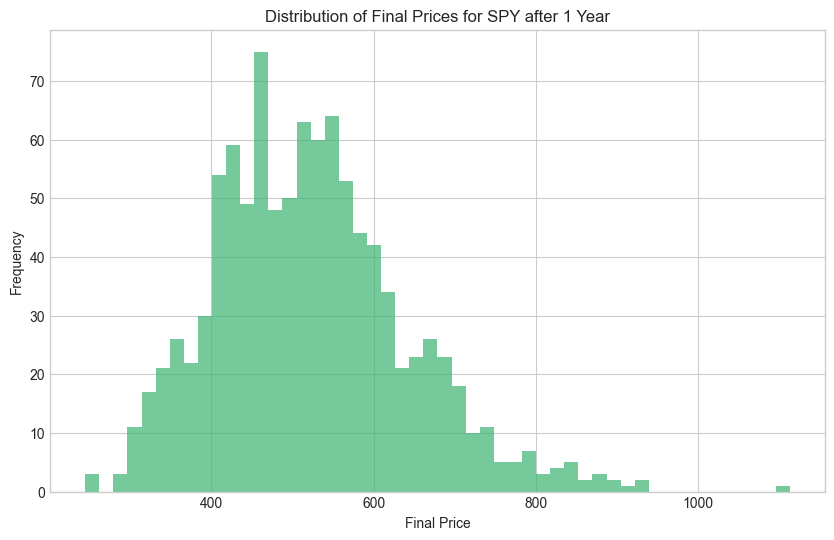

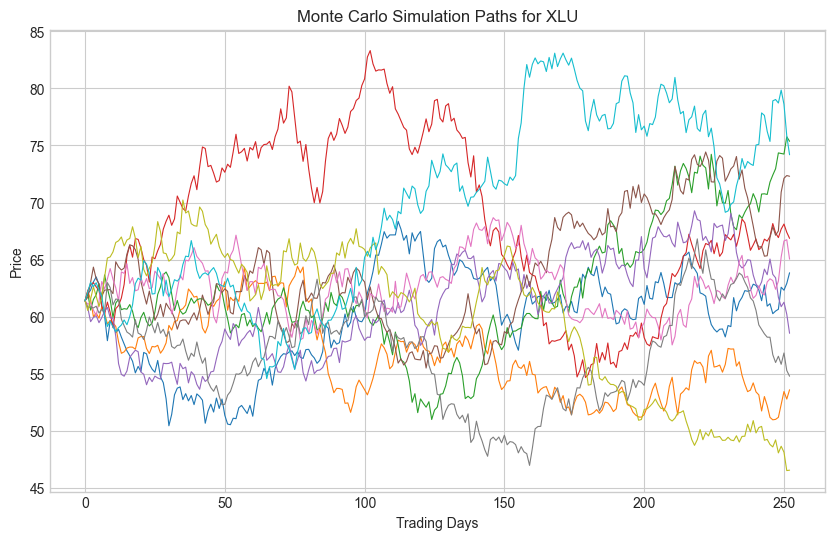

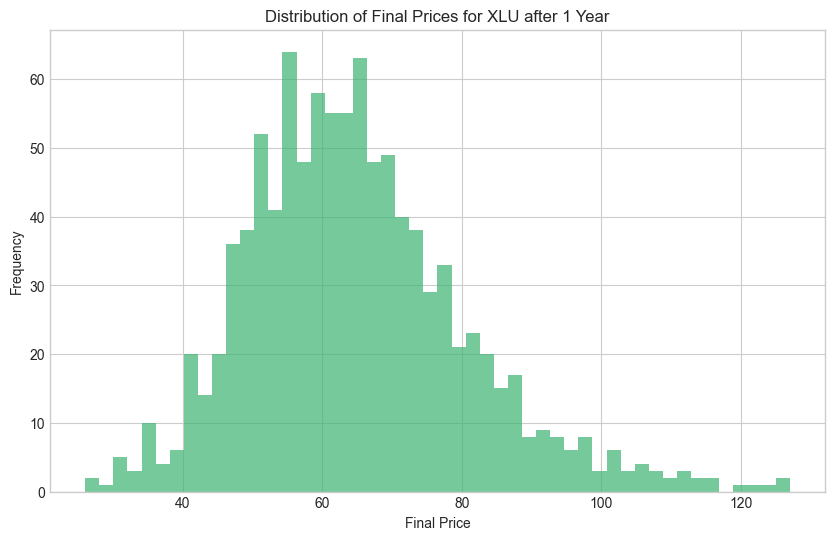

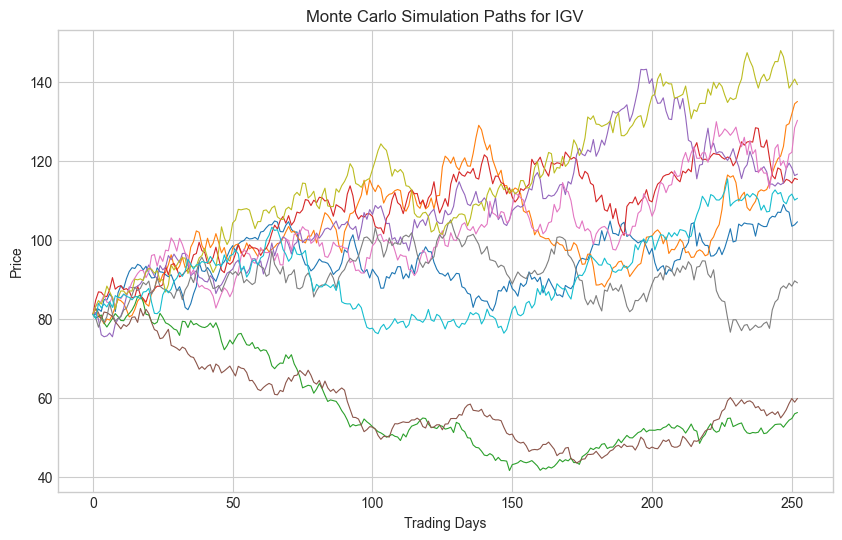

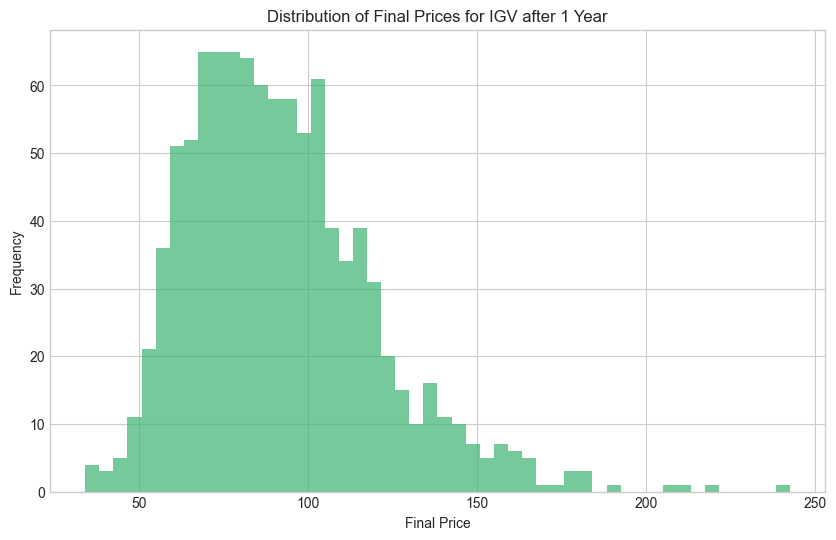

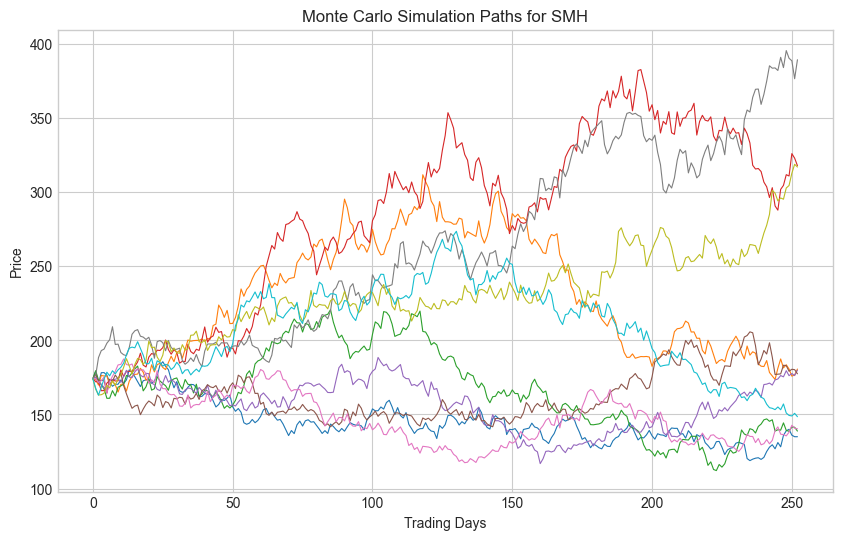

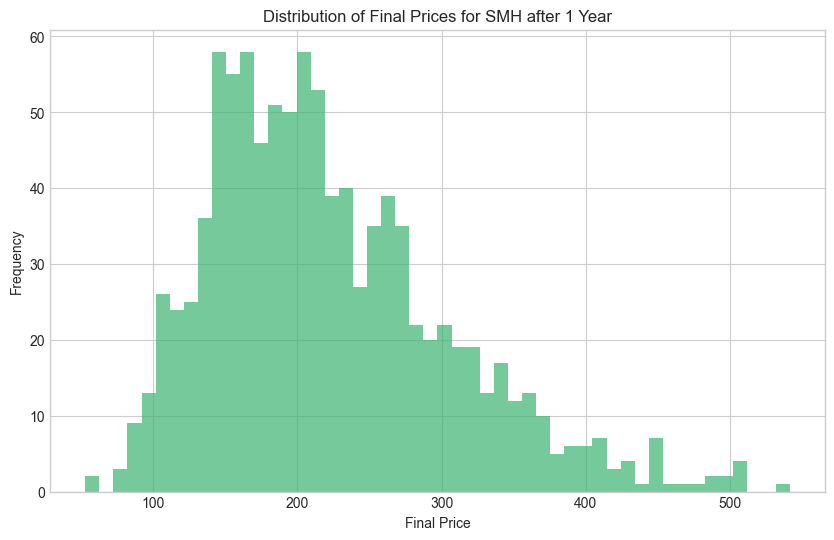

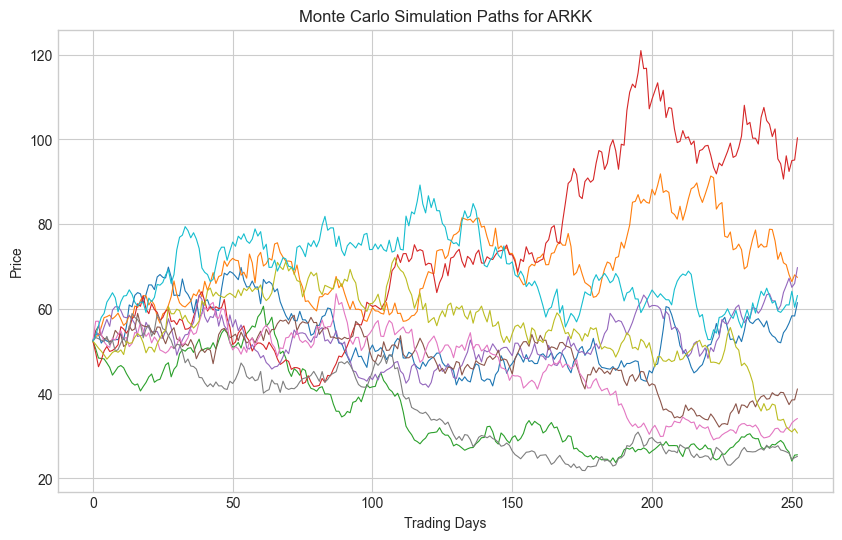

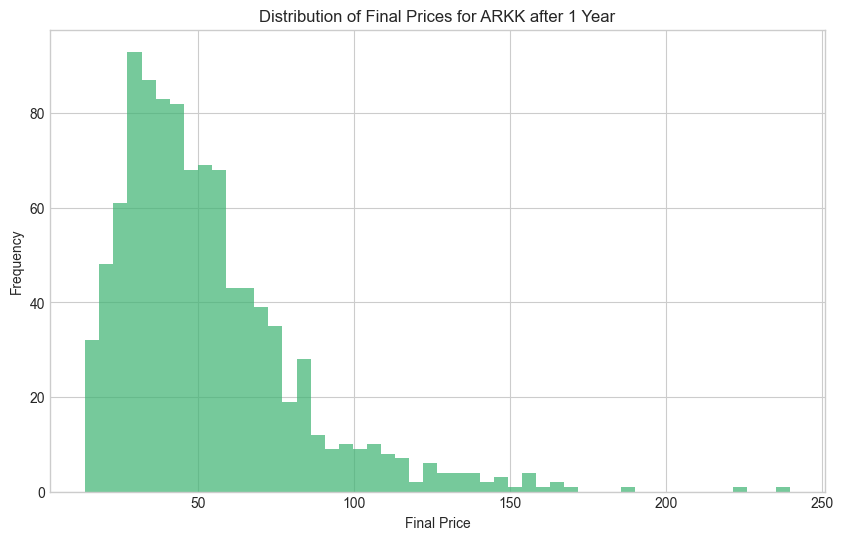

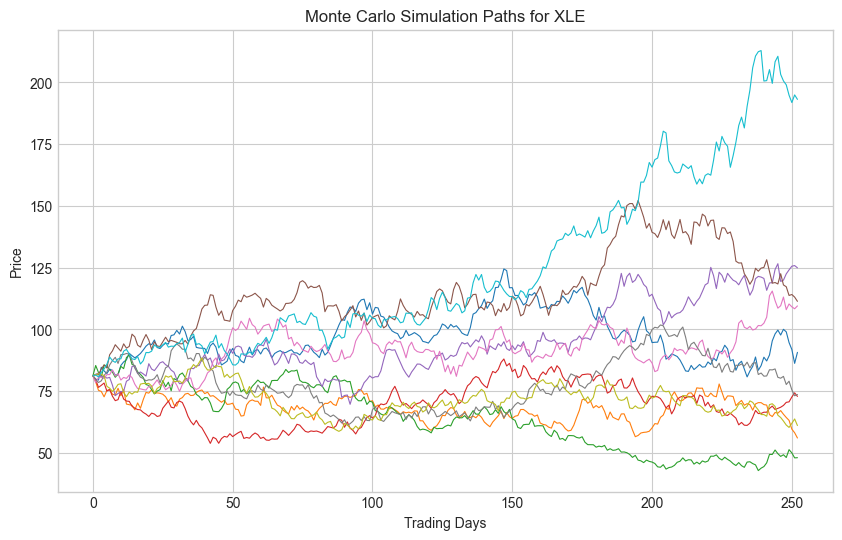

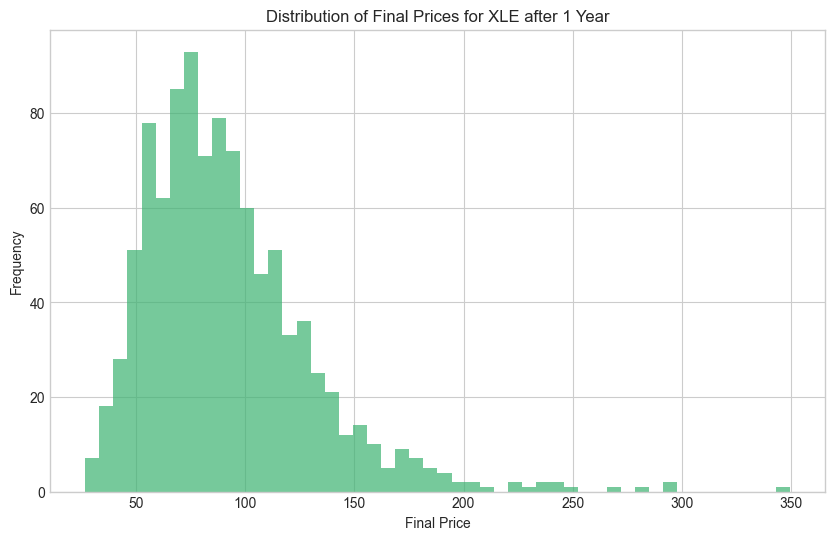

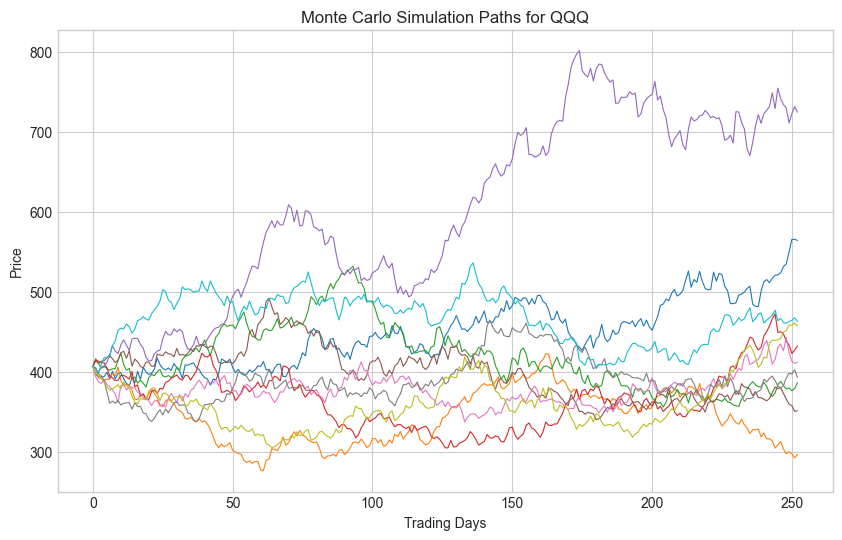

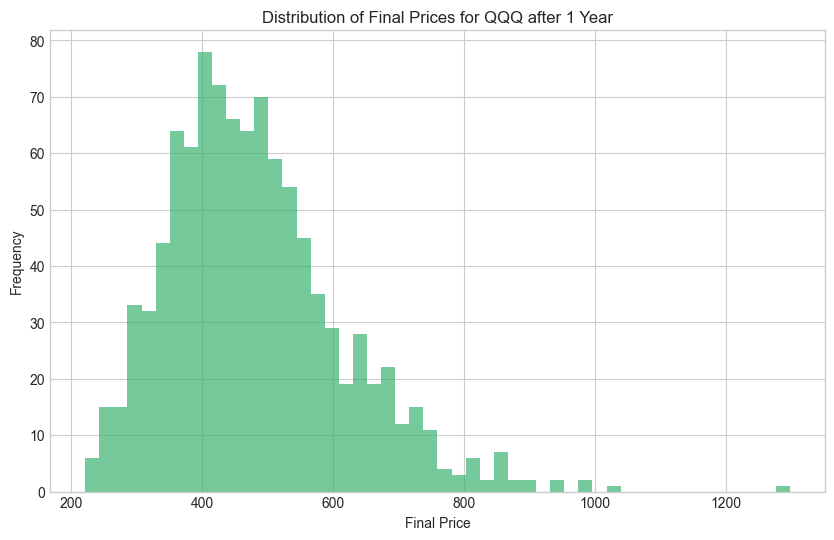

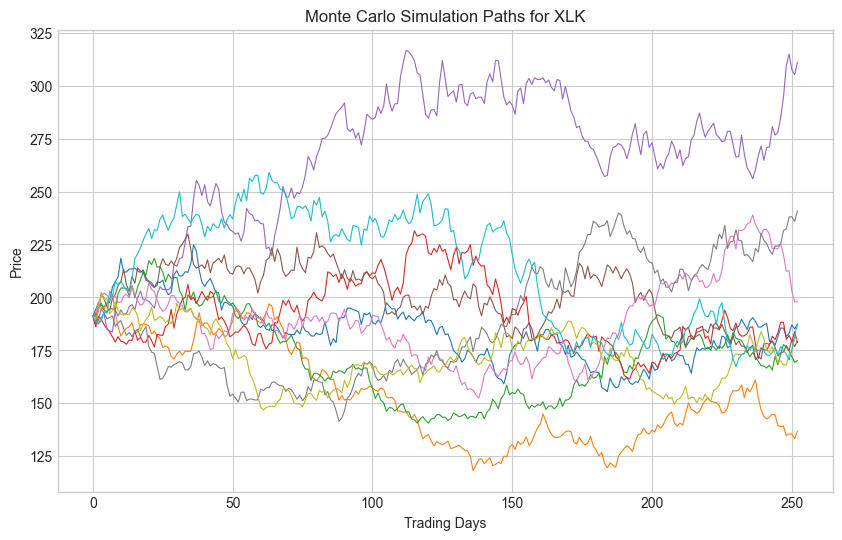

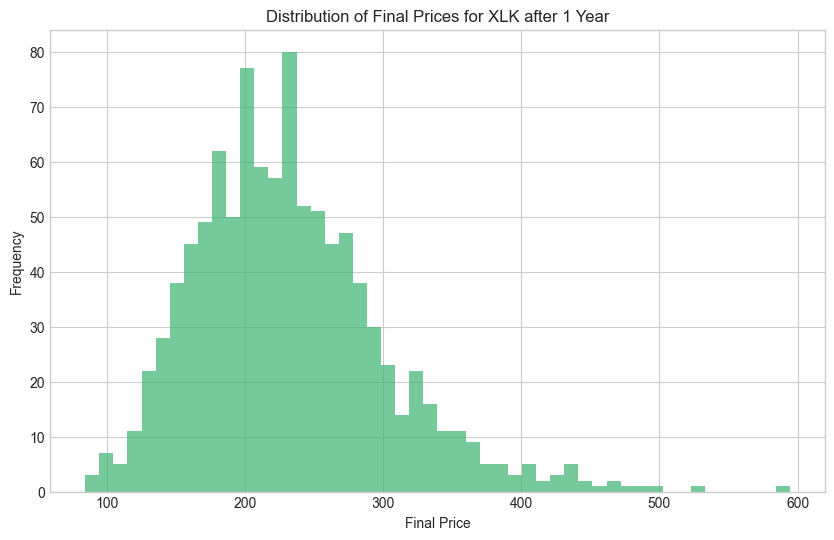

In [12]:
# ### Monte Carlo Simulation for 1-Year Forecast (252 Trading Days)
# 
# For each ETF, we simulate future price paths using the Geometric Brownian Motion (GBM) model:
#
# \[
# S_{t+1} = S_t \times \exp\left((\mu - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t} \, \epsilon\right)
# \]
#
# where \(\epsilon\) is drawn from a standard normal distribution.
#
# We annualize the mean and volatility from our daily log returns for simulation purposes.

T = 1.0     # Time horizon of 1 year
N = 252     # Trading days in a year
dt = T / N  # Time step
num_simulations = 1000  # Number of simulation paths

simulation_results = {}

for etf in etfs:
    S0 = data[etf].iloc[-1]  # current price (last observed)
    # Annualize mean and volatility from daily returns
    mu = log_returns[etf].mean() * 252  
    sigma = log_returns[etf].std() * np.sqrt(252)
    
    sim_prices = np.zeros((N+1, num_simulations))
    sim_prices[0] = S0
    
    # Generate simulated price paths
    for t in range(1, N+1):
        z = np.random.normal(size=num_simulations)
        sim_prices[t] = sim_prices[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*np.sqrt(dt)*z)
    
    simulation_results[etf] = sim_prices
    
    # Plot sample simulation paths (first 10 paths)
    plt.figure(figsize=(10,6))
    plt.plot(sim_prices[:, :10], lw=0.8)
    plt.title(f"Monte Carlo Simulation Paths for {etf}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()
    
    # Plot histogram of final simulated prices
    plt.figure(figsize=(10,6))
    plt.hist(sim_prices[-1], bins=50, alpha=0.7, color='mediumseagreen')
    plt.title(f"Distribution of Final Prices for {etf} after 1 Year")
    plt.xlabel("Final Price")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [13]:
# Calculate simulation statistics for each ETF: mean final price, median, skewness, kurtosis
simulation_stats = pd.DataFrame(index=etfs, columns=["Sim_Mean_Final_Price", "Sim_Median_Final_Price", "Sim_Skewness", "Sim_Kurtosis"])
for etf in etfs:
    final_prices = simulation_results[etf][-1]
    simulation_stats.loc[etf, "Sim_Mean_Final_Price"] = final_prices.mean()
    simulation_stats.loc[etf, "Sim_Median_Final_Price"] = np.median(final_prices)
    simulation_stats.loc[etf, "Sim_Skewness"] = stats.skew(final_prices)
    simulation_stats.loc[etf, "Sim_Kurtosis"] = stats.kurtosis(final_prices)
    
simulation_stats = simulation_stats.astype(float)
print("Monte Carlo Simulation Descriptive Statistics:")
print(simulation_stats)

Monte Carlo Simulation Descriptive Statistics:
      Sim_Mean_Final_Price  Sim_Median_Final_Price  Sim_Skewness  Sim_Kurtosis
SPY             522.023587              513.281889      0.641066      0.765756
XLU              64.807090               63.271408      0.709517      0.938605
IGV              91.837987               87.864807      1.022291      1.896336
SMH             221.834376              206.940069      0.876195      0.694328
ARKK             52.798069               46.642204      1.724194      4.722569
XLE              91.869222               85.412907      1.622277      5.054440
QQQ             481.179500              462.335016      0.965731      1.853043
XLK             231.774230              223.491695      0.917593      1.625128


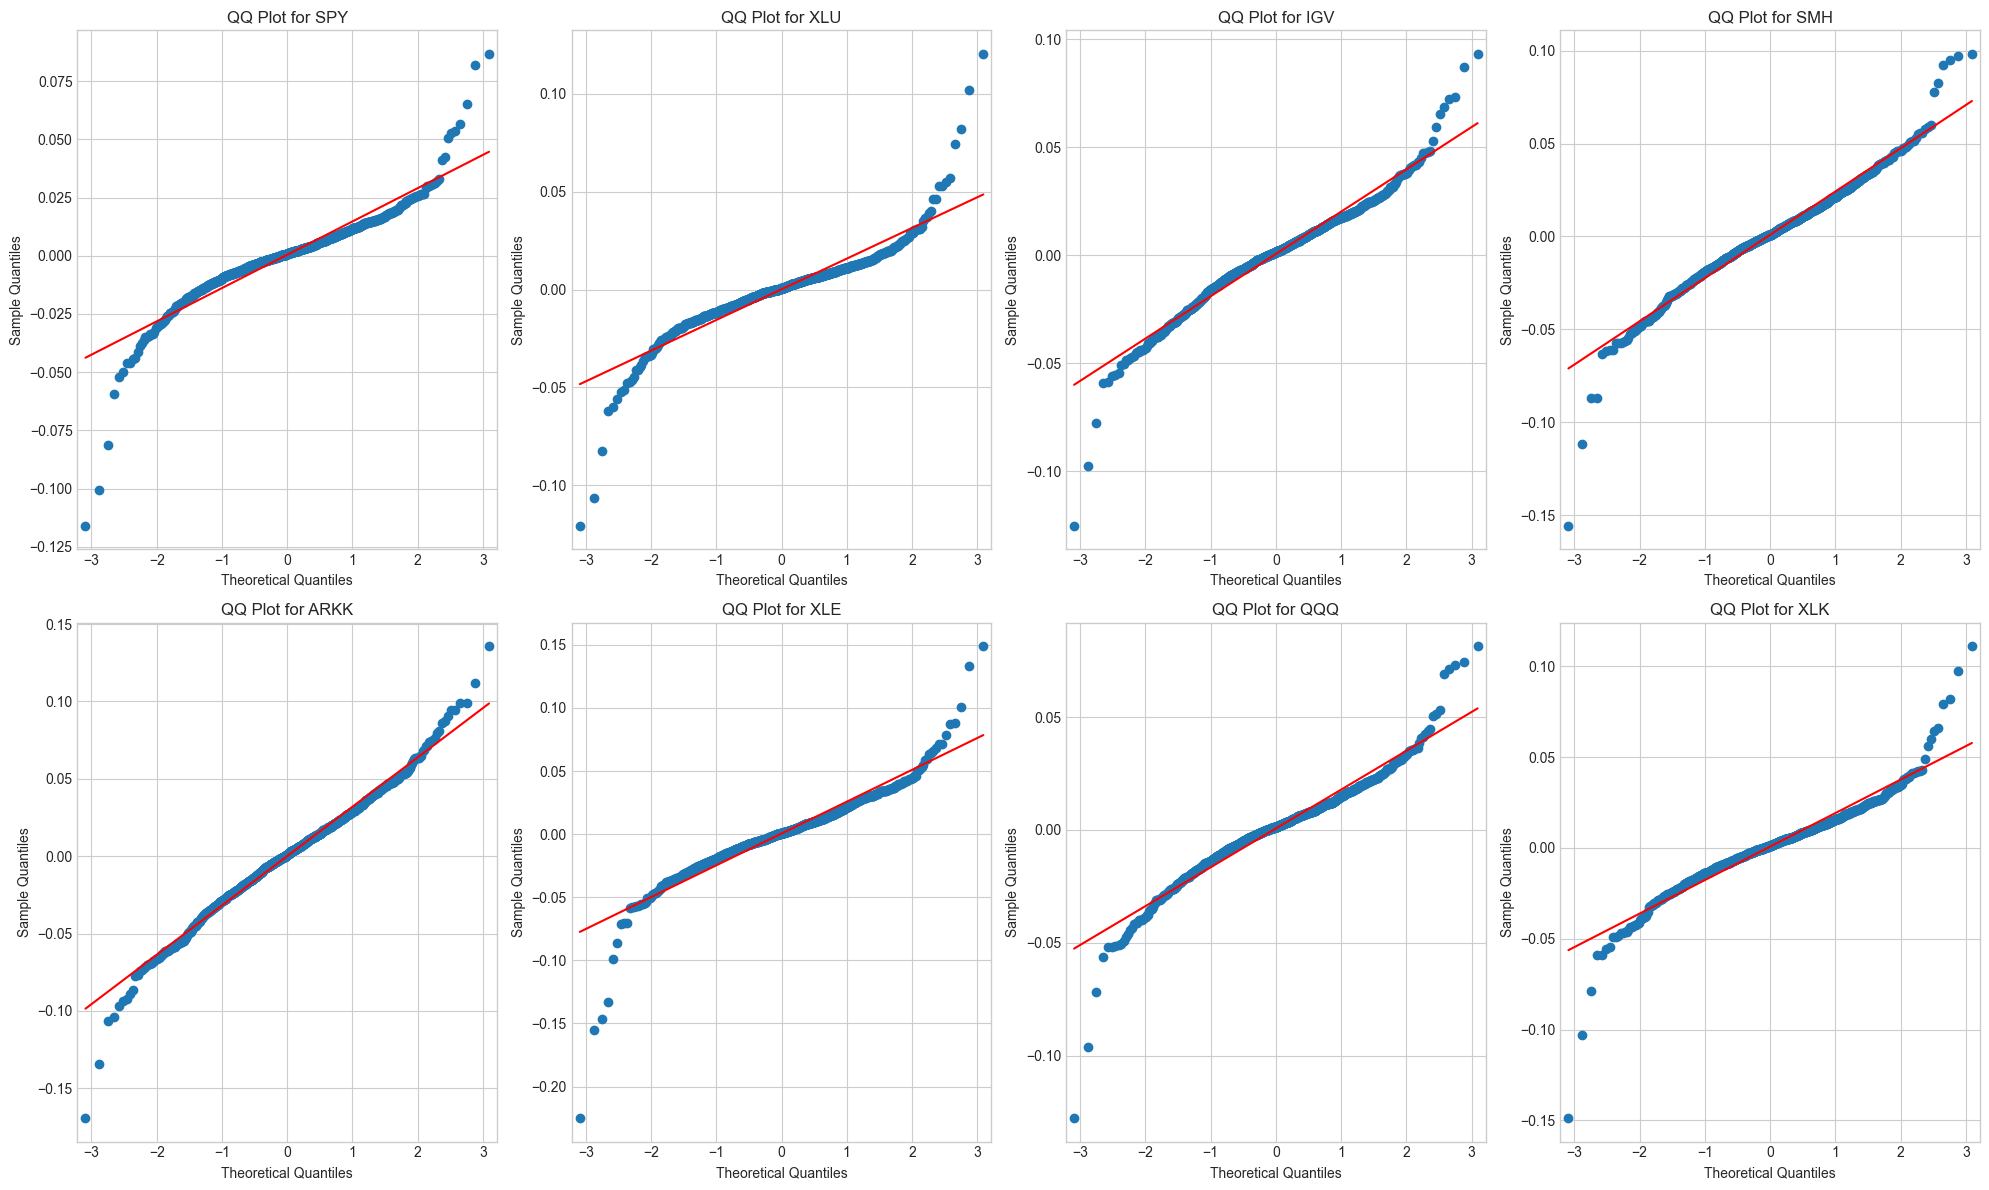

In [14]:
# QQ Plots to check the normality of the historical log returns for each ETF
fig, axes = plt.subplots(2, 4, figsize=(20,12))
axes = axes.flatten()
for i, etf in enumerate(etfs):
    sm.qqplot(log_returns[etf], line='s', ax=axes[i])
    axes[i].set_title(f"QQ Plot for {etf}")
plt.tight_layout()
plt.show()

## Summary & Next Steps

In this notebook, we:

- Downloaded historical data and computed daily log returns.
- Calculated risk metrics (mean, volatility, skewness, kurtosis, VaR).
- Visualized the price history, return distributions, QQ plots, and correlation heatmap.
- Ran Monte Carlo simulations to project one-year future price paths and analyzed the simulated final price distributions.

In the context of the interview question, you can now compare the ETFs based on:

- **Historical skewness and kurtosis:** Indicating how "fat" the right tail is.
- **Simulation results:** Especially the skewness of the final price distributions.
- **Sector trends and economic outlook:** (e.g., tech/innovation ETFs like ARKK or semiconductor ETFs like SMH might show a stronger right tail if growth prospects are robust.)

You can incorporate additional analyses, such as using options-implied volatility or stress testing via Extreme Value Theory, to further strengthen your argument.

Good luck with your interview!